In [8]:
%pip install numpy opencv-python matplotlib scikit-image

     ---------------------------------------- 13.1/13.1 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 39.0/39.0 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 12.8/12.8 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 12.9/12.9 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 225.2/225.2 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 73.8/73.8 kB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 2.7 MB/s eta 0:00:00
     ------------------------------------ 113.9/113.9 kB 664.4 kB/s eta 0:00:00
     ---------------------------------------- 38.7/38.7 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 4.2 MB/s eta 0:00:00
     -------------------------------------- 315.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Sigma range used: 2.0 to 20.0 ( 24 scales )
Detections kept after NMS: 119


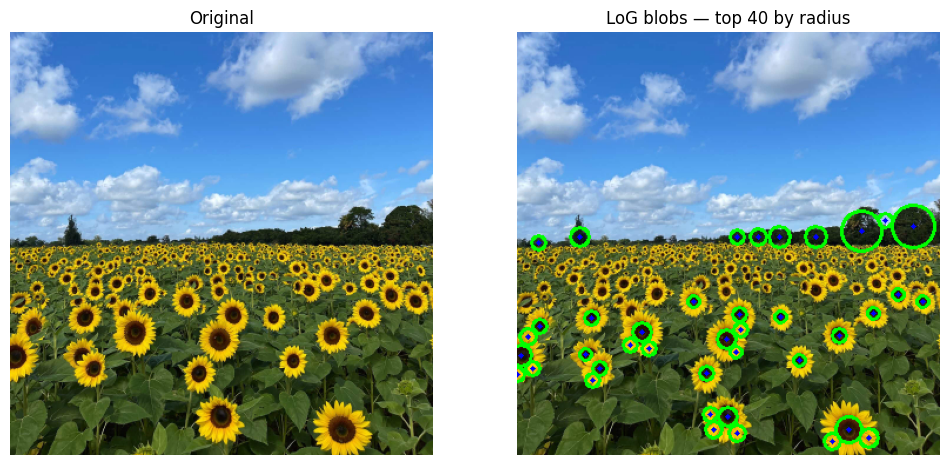


Largest circles (top 10 by radius):
Format: idx: (x, y), radius_px, sigma, response_score
 1: (337, 165), r=18.32px, σ≈12.96, score=1.5420
 2: (293, 169), r=17.22px, σ≈12.17, score=1.5553
 3: (282, 338), r=10.58px, σ≈7.48, score=2.2118
 4: (3, 275), r=9.47px, σ≈6.70, score=1.7924
 5: (223, 174), r=9.47px, σ≈6.70, score=1.5874
 6: (254, 174), r=9.47px, σ≈6.70, score=1.5098
 7: (106, 255), r=8.36px, σ≈5.91, score=2.3286
 8: (178, 261), r=8.36px, σ≈5.91, score=2.2253
 9: (179, 327), r=8.36px, σ≈5.91, score=2.1953
10: (53, 174), r=8.36px, σ≈5.91, score=1.8696

Summary:
 - σ range: [2.00, 20.00] over 24 scales
 - Threshold (quantile): 1.454430
 - Detections before NMS: 141; after NMS: 119


In [ ]:
img_path = 'the_berry_farms_sunflower_field.jpeg' 
im = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
g = cv.cvtColor(im, cv.COLOR_BGR2GRAY).astype(np.float32) / 255.0
H, W = g.shape

sigmas = np.linspace(2.0, 20.0, 24)  # 24 scales from 2 to 20 px
print("Sigma range used:", float(sigmas.min()), "to", float(sigmas.max()), "(", len(sigmas), "scales )")

# 3) Build scale-normalized LoG response volume R[h,w,k] 
def make_log_kernel(s):
    hw = int(math.ceil(3*s))
    y, x = np.mgrid[-hw:hw+1, -hw:hw+1]
    rr = x*x + y*y
    s2 = s*s
    k = (rr - 2*s2) * np.exp(-rr/(2*s2)) / (s**6)
    k -= k.mean()
    return k.astype(np.float32)

R = np.zeros((H, W, len(sigmas)), dtype=np.float32)
for i, s in enumerate(sigmas):
    k = make_log_kernel(s)
    resp = cv.filter2D(g, ddepth=cv.CV_32F, kernel=k, borderType=cv.BORDER_REPLICATE)
    R[..., i] = (s*s) * np.abs(resp)  # scale-normalized, abs to catch bright/dark blobs

# 4) 3D Non-Maximum Suppression (x,y,σ) + thresholding 
thr = np.quantile(R, 0.998)
cands = []

kernel3 = np.ones((3,3), np.uint8)
for i in range(len(sigmas)):
    M = cv.dilate(R[..., i], kernel3)
    mask = (R[..., i] == M) & (R[..., i] >= thr)
    if i > 0:
        mask &= R[..., i] >= R[..., i-1]
    if i < len(sigmas)-1:
        mask &= R[..., i] >= R[..., i+1]
    ys, xs = np.where(mask)
    for y, x in zip(ys, xs):
        cands.append((float(R[y, x, i]), x, y, float(sigmas[i])))

cands.sort(reverse=True, key=lambda t: t[0])

final = []
used = np.zeros(len(cands), dtype=bool)

def too_close(a, b):
    # a,b: (score, x, y, sigma)
    xa, ya, sa = a[1], a[2], a[3]
    xb, yb, sb = b[1], b[2], b[3]
    ra, rb = math.sqrt(2)*sa, math.sqrt(2)*sb
    d2 = (xa-xb)**2 + (ya-yb)**2
    # consider dup if centers are close compared to radii
    return d2 <= (0.5*(ra+rb))**2

for i in range(len(cands)):
    if used[i]: 
        continue
    keep = cands[i]
    used[i] = True
    # suppress neighbors
    for j in range(i+1, len(cands)):
        if used[j]: 
            continue
        if too_close(keep, cands[j]):
            used[j] = True
    final.append(keep)

print(f"Detections kept after NMS: {len(final)}")

# pick largest circles by radius (not score)
with_r = [(s, x, y, math.sqrt(2)*sig) for (s, x, y, sig) in final]
with_r.sort(key=lambda t: t[3], reverse=True)

K_draw = min(40, len(with_r))
out = im.copy()
for i, (score, x, y, r) in enumerate(with_r[:K_draw]):
    cv.circle(out, (int(x), int(y)), int(round(r)), (0, 255, 0), 2)
    # small dot at center
    cv.circle(out, (int(x), int(y)), 2, (255, 0, 0), -1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); plt.title(f"LoG blobs — top {K_draw} by radius"); plt.axis('off')
plt.show()


L = min(10, len(with_r))
print("\nLargest circles (top {} by radius):".format(L))
print("Format: idx: (x, y), radius_px, sigma, response_score")
for i, (score, x, y, r) in enumerate(with_r[:L], 1):
    print(f"{i:2d}: ({int(x)}, {int(y)}), r={r:.2f}px, σ≈{(r/math.sqrt(2)):.2f}, score={score:.4f}")

print("\nSummary:")
print(f" - σ range: [{float(sigmas.min()):.2f}, {float(sigmas.max()):.2f}] over {len(sigmas)} scales")
print(f" - Threshold (quantile): {thr:.6f}")
print(f" - Detections before NMS: {len(cands)}; after NMS: {len(final)}")